# Pima diabetes
Diabetes is a condition where the body's insulin hormone response malfunctions. Glucose reaches dangerously high levels, destroying fine capllaries. This eventually leads to blindness, amputation, or even death.

The glucose and insulin tests are painful, slow, and costly (roughly $20 each).

## Questions for study

- Can cheaper measurements prove reliable enough to recommend further tests?
- How informative are the blood tests?
- Are glucose and insulin tests both necessary?

## Data limitations
The study is biased in a number of important ways:
- **Data has been filtered to remove samples with glucose levels > 200 (positive test for diabetes)**; severe diabetics have been subtly excluded from study.
- Limited to women over 21 years old; men and children may see different patterns of diabetes
- Limited to Pima Indians; they were studied specifically because of a genetic abnormality affecting diabetes
- Conducted in 1990; American diets have changed drastically since then, with a large uptick in diabetes
- The cost of blood tests was estimated in 1990. Glucose finger sticks can now be conducted quickly and cost approximately $0.25.

## Features

A number of features in this dataset should be relevant for predicting diabetes. I have written preliminary notes about their usefulness in our analysis along with each field:
- ** Number of times pregnant**
- **Plasma glucose concentration a 2 hours in an oral glucose tolerance test** 
- **Diastolic blood pressure (mm Hg)**
- **Triceps skin fold thickness (mm)** - may have a negative coefficient when used together with BMI
- **2-Hour serum insulin (mu U/ml)** - correlated with glucose
- **Body mass index (weight in kg/(height in m)^2)**
- **Diabetes pedigree function** - Do relatives have diabetes?
- **Age (years)** - Diabetes is either congenital (Type I) or develops over time in correlation with other factors (Type II). The data may show interaction with different predictors, depending on age of diagnosis. Also, older people have more time to have had their disease diagnosed.

### New features
Other features may prove useful:
- **Pregnant^2** - I expect a single pregnancy to have a large effect (see postscript)
- **Skin\*BMI** - I expect these to interact (see postscript) 
- **BMI^2** - The effect may be more complex than linear

## Null values and correlations
Zeros appear in many columns (example: glucose) where they are biologically impossible. I assume these zeros indicate null.

Pregnancies are correlated with age (makes sense on reflection). They both should be investigated, as they may have different effects.

Most fields are almost entirely populated - and the missing values should be imputed. The insulin test was only completed 51%  of the time (394/768). As expected, glucose, insulin, and diabetes incidence are highly correlated.

I propose four different statistical studies that will help us investigate possible testing strategies:
1. All fields, except blood tests
2. All fields, except insulin test, dropping rows with null glucose
3. All fields, except glucose test, dropping rows with null insulin
4. All fields, dropping rows with null glucose or insulin

Each predictive model is expected to beat 65% accuracy - the accuracy of simply assuming the patient is diabetic. A better goal is 76% sensitivity / specificity (statistics from original study).

## Conclusion



### Postscript

I have personally performed my own research and self-experimentation in this area. Diabetes is part of a related complex of diseases (collectively referred to as "metabolic syndrome" in the medical literature):
- Heart disease
- Stroke
- Cancer
- Alzheimer's (according to some sources)

Specifically, I've been investigating an unorthodox hypothesis: **a root cause of all these diseases is physical compression of the pancreas, leading to poor regulation of glucose.** Glucose, while vital for the body, is highly reactive. It sets off many harmful biological cascades when levels are far different from homeostasis. 

There's a great deal of indirect evidence for this theory, including:
- People who sit (physical compression) for long periods are more likely to develop metabolic syndrome
- People with high central body mass (visceral rather than subcutaneous fat, leading to physical compression) are more likely to develop metabolic syndrome
- Pregnant women (physical compression) sometimes develop "gestational diabetes"
- Women are more likely than men to lay down fat subcutaneously, even though visceral fat is anatomically more efficient (imagine running with weights tied to your ankles vs. carried in a backpack)
- The pancreas is one of the few hormone glands that is not protected from physical pressure

This dataset holds particular interest for me. **Are you aware of other publically available diabetes datasets?**

## Analysis

In [25]:
# Mike Schoeffler
# Reviewer(s):
# 2/5/16 Set up data import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use ggplot style everywhere
# show graphs in notebook
% matplotlib inline 

### Import data

In [113]:
# import the diabetes data set
# change 0s in particular columns (but not all) to null
pima_diabetes = pd.read_csv('pima-indians-diabetes.data', 
    names = ['pregnancies', 'glucose', 'dbp', 'skin_fold', 'insulin', 'bmi', 'pedigree', 'age', 'diabetic'],
    na_values={"glucose" : "0", "dbp" : "0", "skin_fold" : "0", "insulin" : "0", "bmi" : "0"})

# add more features
pima_diabetes['pregnancies2'] = pima_diabetes['pregnancies'] ** 2
pima_diabetes['skin_bmi'] = pima_diabetes['skin_fold'] * pima_diabetes['bmi']
pima_diabetes['bmi2'] = pima_diabetes['bmi'] ** 2

### Explore

In [89]:
pima_diabetes.head()

,pregnancies,glucose,dbp,skin_fold,insulin,bmi,pedigree,age,diabetic,pregnancies2,skin_bmi,bmi2
0,6,148,72,35,NaN,33.6,0.627,50,1,36,1176.0,1128.96
1,1,85,66,29,NaN,26.6,0.351,31,0,1,771.4,707.56
2,8,183,64,NaN,NaN,23.3,0.672,32,1,64,NaN,542.89
3,1,89,66,23,94,28.1,0.167,21,0,1,646.3,789.61
4,0,137,40,35,168,43.1,2.288,33,1,0,1508.5,1857.61


### Summary statistics

In [90]:
pima_diabetes.describe()

,pregnancies,glucose,dbp,skin_fold,insulin,bmi,pedigree,age,diabetic,pregnancies2,skin_bmi,bmi2
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000,768.000000,539.000000,757.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958,26.123698,1006.413173,1101.379062
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951,38.438139,516.695238,483.909494
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000,0.000000,137.200000,331.240000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000,1.000000,613.800000,756.250000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000,9.000000,938.600000,1043.290000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000,36.000000,1323.200000,1339.560000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000,289.000000,3742.200000,4502.410000


In [91]:
pima_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 12 columns):
pregnancies     768 non-null int64
glucose         763 non-null float64
dbp             733 non-null float64
skin_fold       541 non-null float64
insulin         394 non-null float64
bmi             757 non-null float64
pedigree        768 non-null float64
age             768 non-null int64
diabetic        768 non-null int64
pregnancies2    768 non-null int64
skin_bmi        539 non-null float64
bmi2            757 non-null float64
dtypes: float64(8), int64(4)
memory usage: 78.0 KB


In [99]:
pima_diabetes.corr()

,pregnancies,glucose,dbp,skin_fold,insulin,bmi,pedigree,age,diabetic,pregnancies2,skin_bmi,bmi2
pregnancies,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898,0.939780,0.044728,0.000109
glucose,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650,0.114044,0.245083,0.220373
dbp,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589,0.207058,0.277547,0.292433
skin_fold,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491,0.119883,0.935192,0.620160
insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454,0.056563,0.200212,0.206292
bmi,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680,0.064032,0.849344,0.987672
pedigree,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844,-0.009406,0.163099,0.156928
age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356,0.487342,0.119789,0.010584
diabetic,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000,0.219098,0.291799,0.298095
pregnancies2,0.939780,0.114044,0.207058,0.119883,0.056563,0.064032,-0.009406,0.487342,0.219098,1.000000,0.087887,0.048146


## Create four datasets for different screening strategies

In [150]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# standardization: bring all of our features onto the same scale
stdsc = StandardScaler()

pima_neither = pima_diabetes.drop(['glucose', 'insulin'], axis=1)
# the dropped rows may bias the means - use means from this particular dataset 
pima_neither = pima_neither.fillna(pima_neither.mean())
X_neither_std = stdsc.fit_transform(pima_neither.drop('diabetic', axis=1))
X_train_neither, X_test_neither, y_train_neither, y_test_neither = train_test_split(
    X_neither_std, pima_neither['diabetic'],
    test_size=0.2, random_state=7)

pima_glucose = pima_diabetes.drop('insulin', axis=1).dropna(subset=['glucose'])
# the dropped rows may bias the means - use means from this particular dataset 
pima_glucose = pima_glucose.fillna(pima_glucose.mean())
pima_glucose_std = stdsc.fit_transform(pima_glucose)
X_glucose_std = stdsc.fit_transform(pima_glucose.drop('diabetic', axis=1))
X_train_glucose, X_test_glucose, y_train_glucose, y_test_glucose = train_test_split(
    X_glucose_std, pima_glucose['diabetic'], 
    test_size=0.2, random_state=7)

pima_insulin = pima_diabetes.drop('glucose', axis=1).dropna(subset=['insulin'])
# the dropped rows may bias the means - use means from this particular dataset 
pima_insulin = pima_insulin.fillna(pima_insulin.mean())
pima_insulin_std = stdsc.fit_transform(pima_insulin)
X_insulin_std = stdsc.fit_transform(pima_insulin.drop('diabetic', axis=1))
X_train_insulin, X_test_insulin, y_train_insulin, y_test_insulin = train_test_split(
    X_insulin_std, pima_insulin['diabetic'], 
    test_size=0.2, random_state=7)

pima_both = pima_diabetes.dropna(subset = ['insulin', 'glucose'], how = 'any')
# the dropped rows may bias the means - use means from this particular dataset 
pima_both = pima_both.fillna(pima_both.mean())
pima_both_std = stdsc.fit_transform(pima_both)
X_both_std = stdsc.fit_transform(pima_both.drop('diabetic', axis=1))
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(
    X_both_std, pima_both['diabetic'], 
    test_size=0.2, random_state=7)

y_train_glucose.head()

673    0
424    1
749    1
430    0
291    1
Name: diabetic, dtype: int64

### Find minimum accuracy for the data sets used in testing each strategy

In [152]:
# how many have diabetes?
y_test_neither.value_counts() / y_test_neither.shape[0]

0    0.62987
1    0.37013
Name: diabetic, dtype: float64

In [153]:
# how many have diabetes?
y_test_glucose.value_counts() / y_test_glucose.shape[0]

0    0.640523
1    0.359477
Name: diabetic, dtype: float64

In [154]:
# how many have diabetes?
y_test_insulin.value_counts() / y_test_insulin.shape[0]

0    0.670886
1    0.329114
Name: diabetic, dtype: float64

In [155]:
# how many have diabetes?
y_test_both.value_counts() / y_test_both.shape[0]

0    0.607595
1    0.392405
Name: diabetic, dtype: float64

## Visualize data

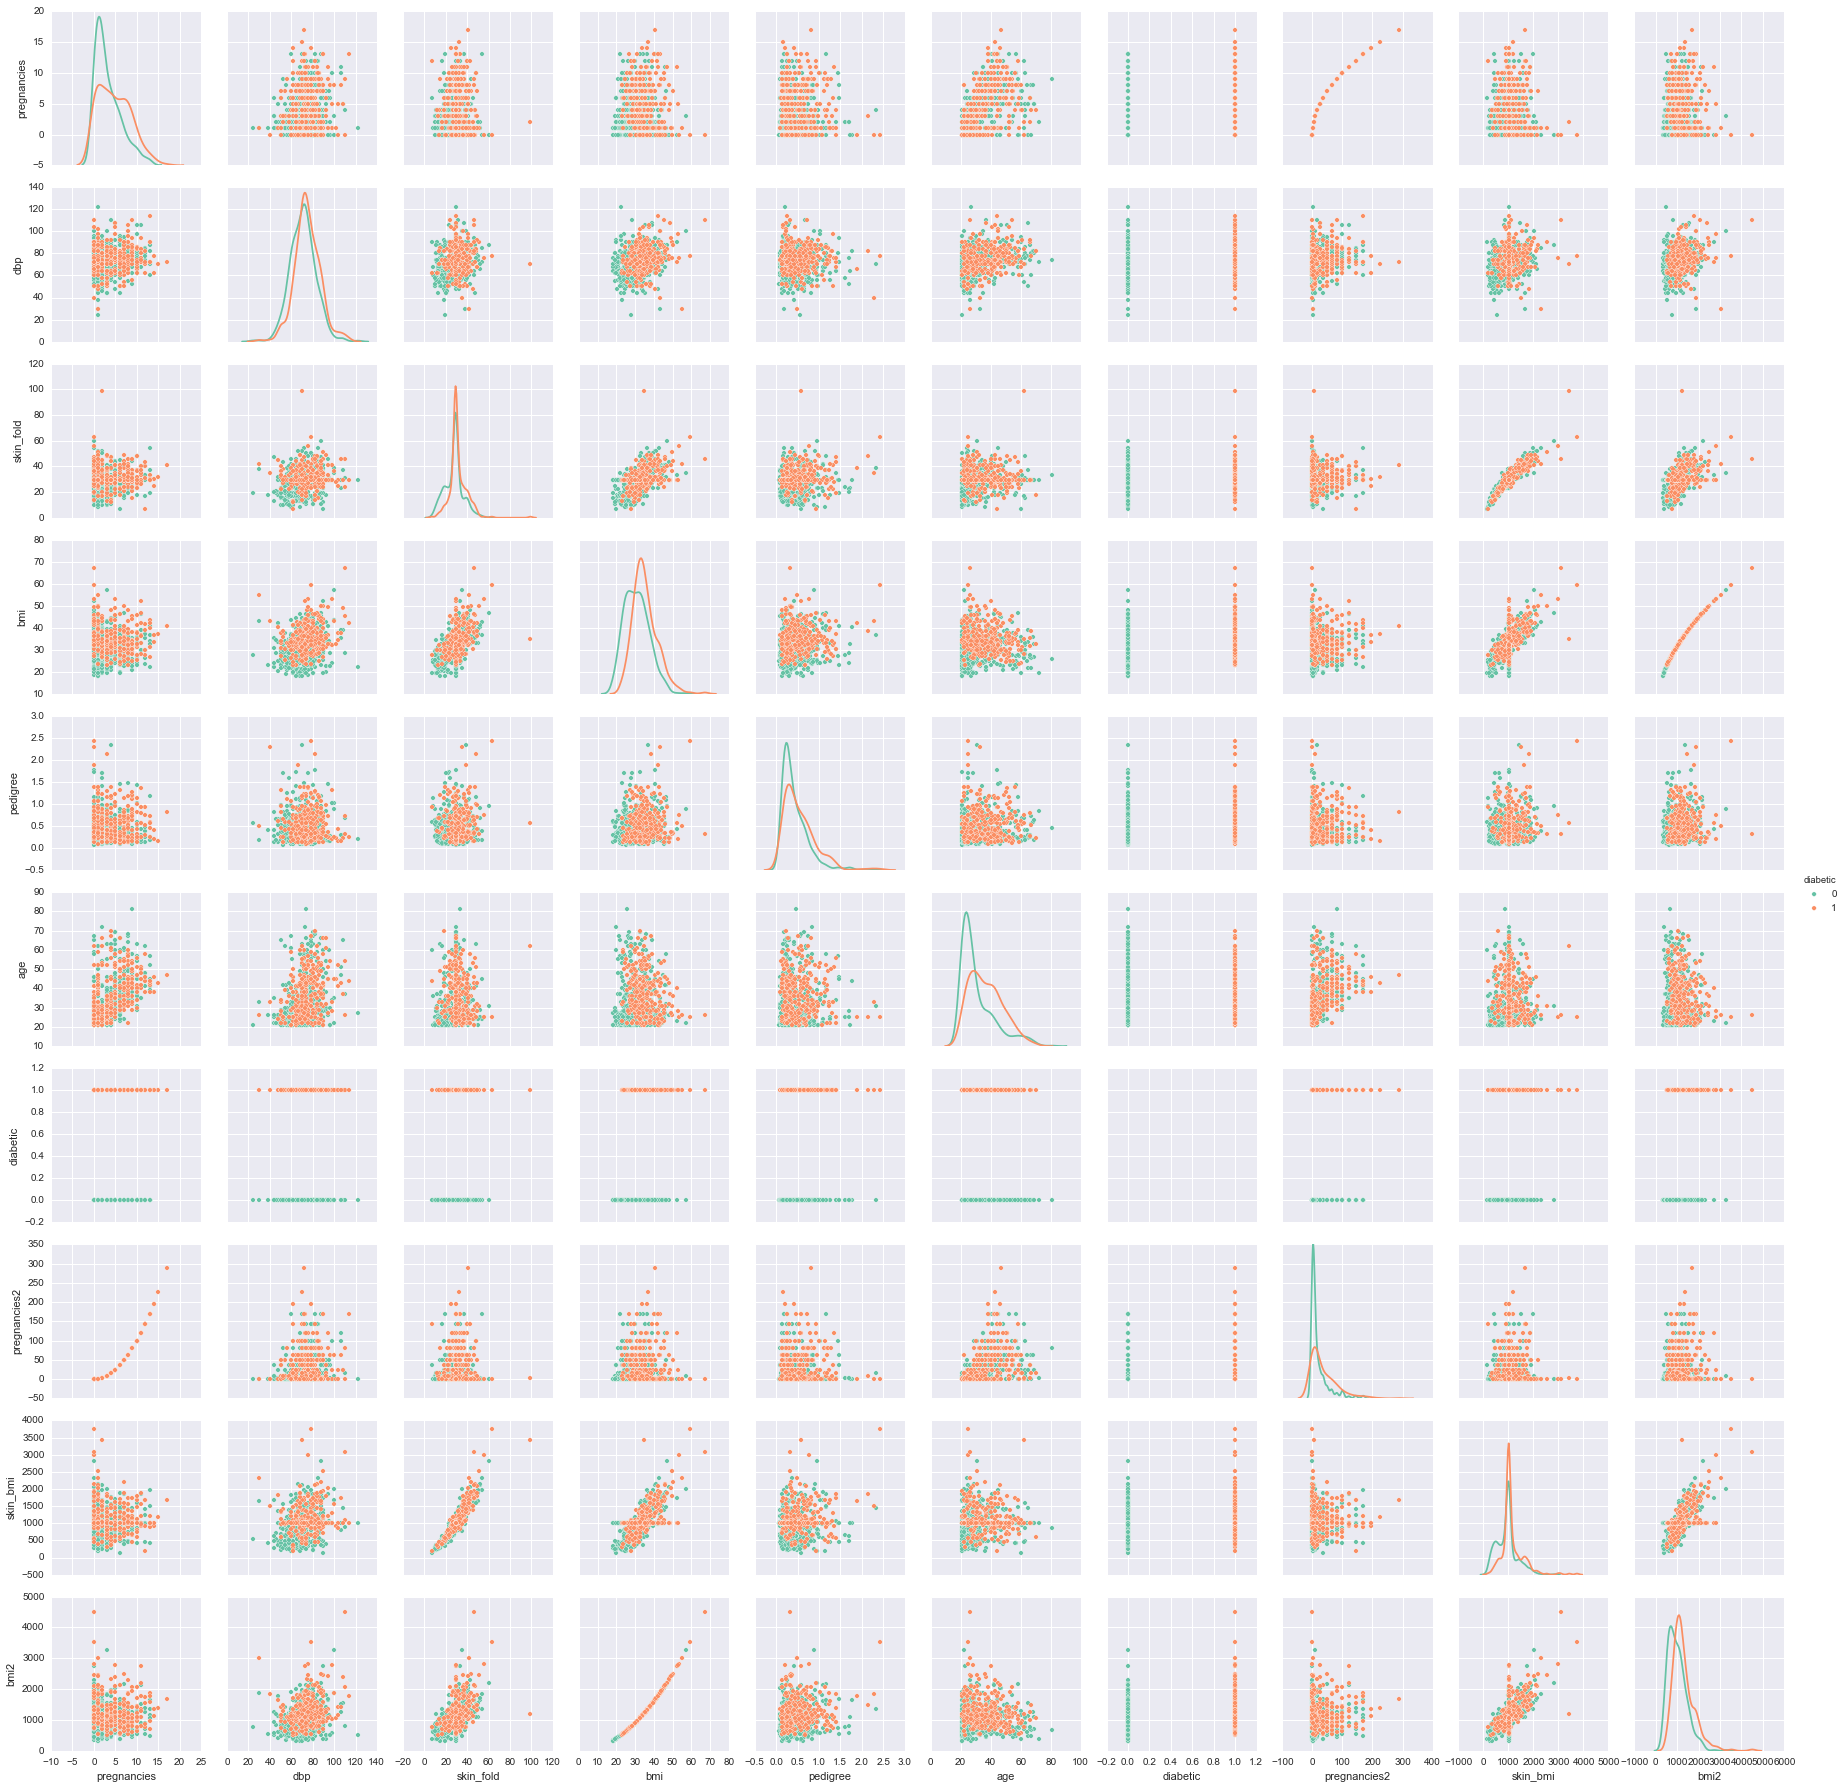

In [156]:
g = sns.pairplot(pima_neither, hue="diabetic", palette="Set2", diag_kind="kde", size=2.5)

## Build predictions for each model

### kNN

In [129]:
# %%timeit # times cell
# 10 cross validation iterations with 20% test / 80% train
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_neither_std.shape[0], n_iter=10, test_size=0.2, random_state=0)
# k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
# starting with k=1
# this creates the classifier
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', p=2)
# execute this to fit the classifier to our data
# knn.fit(X_no_tests, y_no_tests)
# execute this to predict the labels for our "unseen" test data
# knn.predict(test)

# gridsearch for hyperparameters
from sklearn.grid_search import GridSearchCV
# the parameters we want to search in a dictionary
# use the parameter name from sklearn as the key
# and the possible values you want to test as the values
parameters = {'n_neighbors': range(1,30), 'weights': ['uniform', 'distance'],
             'p': range(1,4)}
clf = GridSearchCV(knn, parameters, cv=cv)
clf.fit(X_neither_std, y_no_tests)
# get a list of all the combo scores
#clf.grid_scores_

GridSearchCV(cv=ShuffleSplit(768, n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [125]:
clf.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}

<module 'matplotlib.pyplot' from '//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

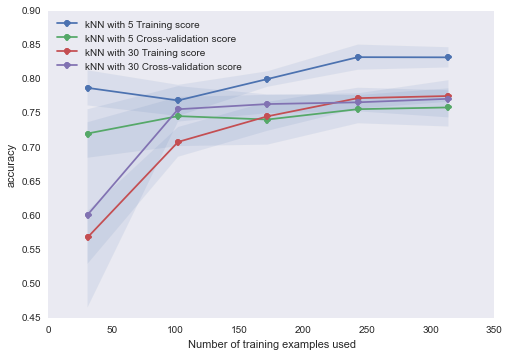

In [134]:
from sk_modelcurves.learning_curve import draw_learning_curve
knn5 = KNeighborsClassifier(n_neighbors=5)
knn30 = KNeighborsClassifier(n_neighbors=30)
# draw_learning_curve([knn5, knn50], X_no_tests_std, y_no_tests, estimator_titles=['kNN with 5', 'kNN with 50'], cv=5, scoring='accuracy')
draw_learning_curve([knn5, knn30], X_both_std, y_both, estimator_titles=['kNN with 5', 'kNN with 30'], cv=5,
                   scoring='accuracy')